<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "EP"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/EP/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


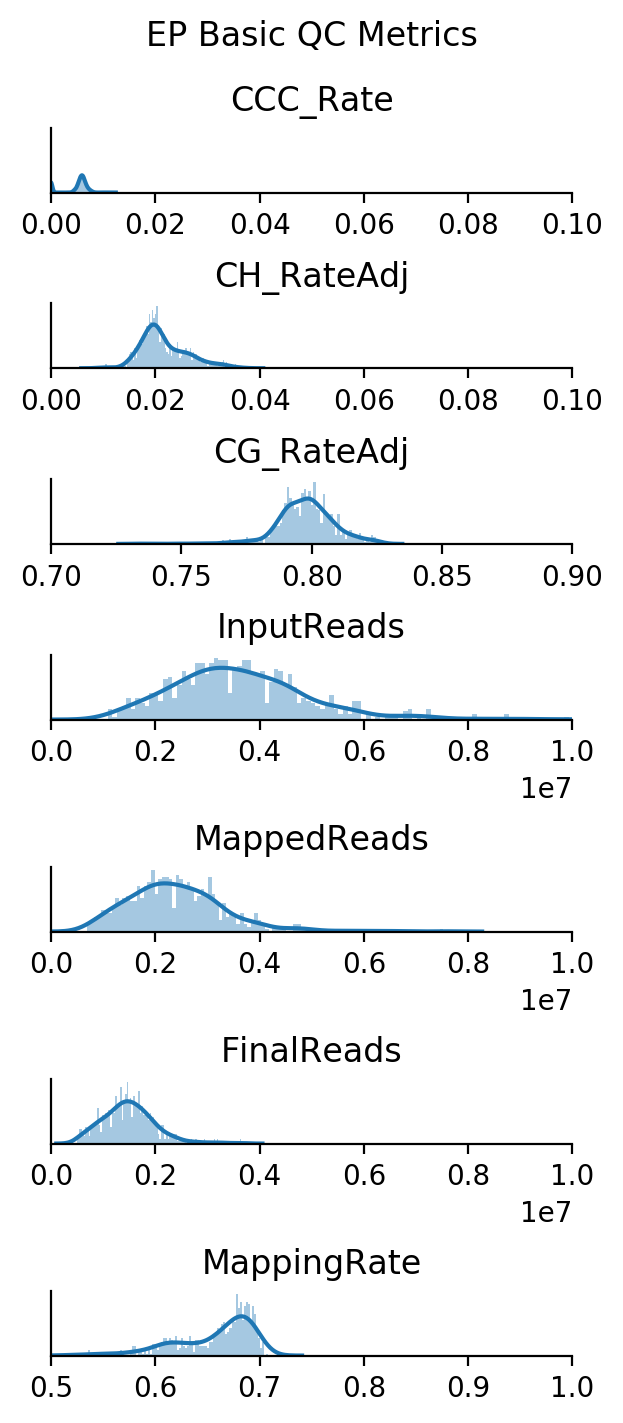

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

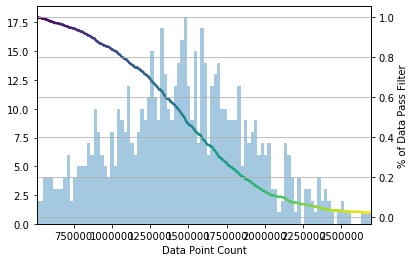

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 666/666 (100.0%)
CG_RateAdj passed 666/666 (100.0%)
CH_RateAdj passed 666/666 (100.0%)
FinalReads passed 666/666 (100.0%)
MappingRate passed 666/666 (100.0%)
Overall passed 666/666 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171214 8
171219 12
180109 22
180220 16
180222 21
180313 7
180319 3
180320 48
180326 37
180329 38
180402 39
180403 30
180405 21
180412 7
180416 7
180925 2
181008 59
181009 66
181206 5
181218 7
181220 8
190122 1
190131 80
190205 121
190212 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 85 22.1%
ad002 81 21.1%
ad004 93 24.2%
ad006 77 20.1%
ad007 83 21.6%
ad008 79 20.6%
ad010 80 20.8%
ad012 88 22.9%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
2D_M_1052,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180319_2D...,0.005760,0.792120,0.790920,0.025360,0.019710,1272372.0,2779318,1861814.0,2D,...,-3.180920,-24.105116,-25.493853,9.022044,EP,7.312562,0.919347,13.298667,-23.155672,True
2D_M_1077,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.005450,0.793710,0.792580,0.025370,0.020030,1584587.0,3750034,2441685.0,2D,...,-3.001496,-24.407574,-26.075838,8.992022,EP,7.935264,0.517457,12.468464,-23.265229,True
2D_M_109,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180313_2D...,0.004430,0.779940,0.778960,0.021530,0.017180,1250946.0,2882342,1891381.0,2D,...,-2.823999,-24.309196,-25.546590,8.927735,EP,7.753075,0.714313,13.137963,-22.864862,True
2D_M_1128,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180319_2D...,0.004520,0.787140,0.786170,0.019940,0.015490,1273184.0,2886510,1922884.0,2D,...,-2.816237,-24.553541,-25.298076,8.839714,EP,7.368381,1.011794,14.415321,-22.239285,True
2D_M_1199,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.005140,0.793660,0.792590,0.024130,0.019090,1318712.0,3000122,1986630.0,2D,...,-3.247427,-24.269114,-25.801654,8.876567,EP,7.649111,0.623253,12.736369,-23.435428,True
2D_M_1223,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.004720,0.797310,0.796350,0.021810,0.017170,1085727.0,2468534,1634700.0,2D,...,-2.860736,-24.994991,-26.659138,8.790568,EP,8.343713,0.376749,11.496936,-22.560356,True
2D_M_125,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180313_2D...,0.005170,0.792170,0.791090,0.024770,0.019700,1293481.0,3009358,1957843.0,2D,...,-3.271294,-24.230932,-25.858488,8.850154,EP,7.783766,0.554840,12.657567,-23.421471,True
2D_M_1304,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.004570,0.801700,0.800790,0.022640,0.018150,654146.0,1360720,899732.0,2D,...,-2.877046,-25.698803,-28.968838,9.210293,EP,9.701244,-0.532824,9.207060,-21.892711,True
2D_M_1332,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.006100,0.786710,0.785400,0.021640,0.015640,1541504.0,3771114,2405826.0,2D,...,-2.873899,-24.316233,-24.483144,8.632084,EP,6.682064,1.656404,15.283218,-21.808019,True
